In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from keras.datasets import mnist
import itertools
import random
random.seed(42)
plt.style.use('dark_background')

Using TensorFlow backend.


In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
train_images.shape

(60000, 28, 28)

Randomly sampling a subset of the data, to make the combinations more tractable. 

(28, 28)


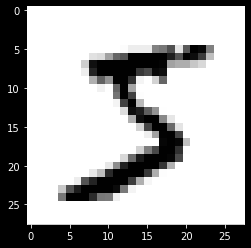

In [4]:
image_A = train_images[0]
print(image_A.shape)
plt.imshow(image_A, cmap = plt.cm.binary)

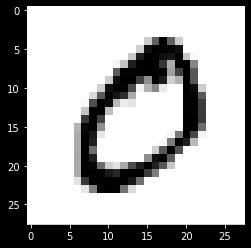

In [5]:
image_B = train_images[1]
plt.imshow(image_B, cmap = plt.cm.binary)

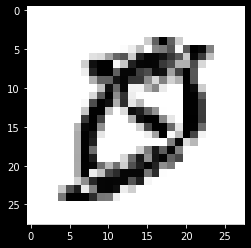

In [6]:
images_A_and_B = image_A + image_B
plt.imshow(images_A_and_B, cmap = plt.cm.binary)

In [7]:
# Create mini training set so that it's not too computationally intensive
sample_size = 40000
X_train, X_val, y_train, y_val = train_images[:sample_size], train_images[sample_size:sample_size*2],  train_labels[:sample_size], train_labels[sample_size:sample_size*2]

In [8]:
# fold = X_train.shape[0]//2
# X_train_A, X_train_B, y_train_A, y_train_B = X_train[:fold], X_train[fold:], y_train[fold:], y_train[:fold]

# val_fold = X_val.shape[0]//2
# X_val_A, X_val_B, y_val_A, y_val_B = X_val[:val_fold], X_val[val_fold:], y_val[val_fold:], y_val[:val_fold]


In [9]:
# Randomly draw 40k training images

num_images_chosen = 80000
num_images_total = 40000

combo_train_X = []
combo_train_y = []

for i in range(num_images_chosen):
    
    # Randomly draw indices
    rand_A = random.randint(0, num_images_total-1)
    rand_B = random.randint(0, num_images_total-1)
    
    # Concatenate images
    image_A = X_train[rand_A]
    image_B = X_train[rand_B]
    concatenated_images = image_A + image_B
    
    # Find the minimum label
    intermediate_label_A = y_train[rand_A]
    intermediate_label_B = y_train[rand_B]
    minimum_label = min(intermediate_label_A, intermediate_label_B)
    
    # Append to lists
    combo_train_X.append(concatenated_images)
    combo_train_y.append(minimum_label)
    
combo_train_X = np.array(combo_train_X)
combo_train_y = np.array(combo_train_y)

In [10]:
# Randomly draw 20k validation images

num_images_chosen = 10000
num_images_total = 20000

combo_val_X = []
combo_val_y = []

for i in range(num_images_chosen):
    
    # Randomly draw indices
    rand_A = random.randint(0, num_images_total-1)
    rand_B = random.randint(0, num_images_total-1)
    
    # Concatenate images
    image_A = X_val[rand_A]
    image_B = X_val[rand_B]
    concatenated_images = image_A + image_B
    
    # Find the minimum label
    intermediate_label_A = y_val[rand_A]
    intermediate_label_B = y_val[rand_B]
    minimum_label = min(intermediate_label_A, intermediate_label_B)
    
    # Append to lists
    combo_val_X.append(concatenated_images)
    combo_val_y.append(minimum_label)
    
combo_val_X = np.array(combo_val_X)
combo_val_y = np.array(combo_val_y)

In [11]:
combo_val_X.shape

(10000, 28, 28)

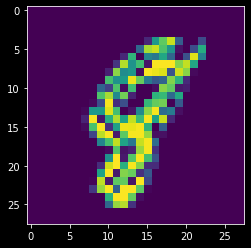

In [12]:
plt.imshow(combo_val_X[1000])

In [13]:
combo_val_y[1000]

8

In [14]:
train_images = combo_train_X.reshape((combo_train_X.shape[0], 28, 28, 1))
train_images = train_images.astype('float32')/ 255

val_images = combo_val_X.reshape((combo_val_X.shape[0], 28, 28, 1))
val_images = val_images.astype('float32')/255

train_labels = to_categorical(combo_train_y)
val_labels = to_categorical(combo_val_y)

In [15]:
train_images.shape

(80000, 28, 28, 1)

In [16]:
val_images.shape

(10000, 28, 28, 1)

In [17]:
train_labels.shape

(80000, 10)

In [18]:
model = tf.keras.Sequential()
model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (28,28,1)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
# Adding a classifier
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(10, activation = 'softmax'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dropout (Dropout)            (None, 576)               0

In [20]:

opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(optimizer = opt,
             loss = 'categorical_crossentropy',
             metrics = ['mae'])

# model.compile(optimizer = 'rmsprop',
#              loss = 'categorical_crossentropy',
#              metrics = ['accuracy', 'mae'])


In [21]:
# Run model in one go
model.reset_states()
history = model.fit(train_images, 
          train_labels, 
          epochs = 30, 
          batch_size = 64,
          validation_data = (val_images, val_labels))


#     history = model.fit(partial_train_data,
#               partial_train_targets,
#               validation_data = (val_data, val_targets),
#               epochs = num_epochs,
#               batch_size = 64,
#               verbose = 0)

val_mae_history = history.history['val_mae']
print(val_mae_history)
#val_acc_history = history.history['accuracy']
#print(history.history.keys())
#all_mae_histories.append(val_mae_history)

Epoch 1/30
1250/1250 [==============================] - 24s 19ms/step - loss: 0.8230 - mae: 0.0774 - val_loss: 0.4487 - val_mae: 0.0459
Epoch 2/30
1250/1250 [==============================] - 23s 19ms/step - loss: 0.4911 - mae: 0.0478 - val_loss: 0.3649 - val_mae: 0.0380
Epoch 3/30
1250/1250 [==============================] - 24s 19ms/step - loss: 0.4079 - mae: 0.0396 - val_loss: 0.3221 - val_mae: 0.0327
Epoch 4/30
1250/1250 [==============================] - 28s 22ms/step - loss: 0.3631 - mae: 0.0352 - val_loss: 0.2996 - val_mae: 0.0293
Epoch 5/30
1250/1250 [==============================] - 26s 21ms/step - loss: 0.3339 - mae: 0.0323 - val_loss: 0.2794 - val_mae: 0.0260
Epoch 6/30
1250/1250 [==============================] - 25s 20ms/step - loss: 0.3065 - mae: 0.0296 - val_loss: 0.2990 - val_mae: 0.0265
Epoch 7/30
1250/1250 [==============================] - 25s 20ms/step - loss: 0.2936 - mae: 0.0282 - val_loss: 0.2601 - val_mae: 0.0262
Epoch 8/30
1250/1250 [==========================

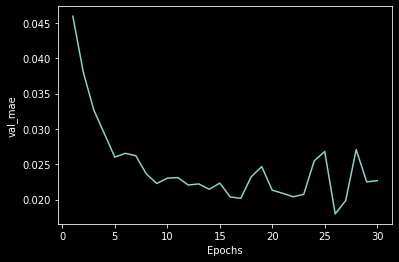

In [22]:
plt.plot(range(1, len(val_mae_history) + 1), val_mae_history)
plt.xlabel('Epochs')
plt.ylabel('val_mae')
plt.show()

In [23]:
y_predict = model.predict(val_images)
#y_predict = y_predict.astype(int)


correct = 0
#check_baseline

for label in range(len(val_labels)):
    
    if np.argmax(val_labels[label], axis=None, out=None) == np.argmax(y_predict[label], axis=None, out=None):
        correct = correct + 1
        
print("Val Accuracy: " + str(correct/len(val_labels)))

Val Accuracy: 0.9125


Baseline for above is 10%

In [24]:
eval_model = model.evaluate(val_images, val_labels)
eval_model

313/313 [==============================] - 1s 2ms/step - loss: 0.3010 - mae: 0.0227


[0.30102744698524475, 0.02268015220761299]

In [23]:
# Perform k-fold cross-validation
# Set up parameters for cross-validation
k = 2
num_val_samples = len(train_images)//k

num_epochs = 30
all_mae_histories = []

for i in range(k):
    
    print('processing fold #', i)
    val_data = train_images[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_labels[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
    [train_images[:i * num_val_samples],
    train_images[(i+1) * num_val_samples:]],
    axis = 0)
    
    partial_train_targets = np.concatenate(
    [train_labels[:i*num_val_samples],
    train_labels[(i+1)*num_val_samples:]],
    axis = 0)
    
    model.reset_states()
    history = model.fit(partial_train_data,
              partial_train_targets,
              validation_data = (val_data, val_targets),
              epochs = num_epochs,
              batch_size = 64,
              verbose = 0)
    
    val_mae_history = history.history['val_mae']
    print(val_mae_history)
    #val_acc_history = history.history['accuracy']
    #print(history.history.keys())
    all_mae_histories.append(val_mae_history)

processing fold # 0
[0.10015103965997696, 0.07854054868221283, 0.06976654380559921, 0.06518711894750595, 0.06123950332403183, 0.0586366206407547, 0.04995421692728996, 0.061121199280023575, 0.0504055954515934, 0.04447520896792412, 0.039783328771591187, 0.04706171154975891, 0.04072960093617439, 0.04122878238558769, 0.03526578098535538, 0.03635024279356003, 0.04414273425936699, 0.033674128353595734, 0.03839120641350746, 0.03324676677584648, 0.03246698155999184, 0.03291046991944313, 0.03284728527069092, 0.03280035778880119, 0.03326550871133804, 0.03363596275448799, 0.03037921153008938, 0.032406944781541824, 0.0329052172601223, 0.031927548348903656]
processing fold # 1
[0.018611304461956024, 0.01897256076335907, 0.017715128138661385, 0.018661780282855034, 0.016278764232993126, 0.02344367280602455, 0.01580817624926567, 0.020697953179478645, 0.019673166796565056, 0.015816258266568184, 0.018120383843779564, 0.020183753222227097, 0.02121661975979805, 0.019098425284028053, 0.01920454204082489, 0

In [ ]:
# Perform k-fold cross-validation
# Set up parameters for cross-validation
k = 2
num_val_samples = len(train_images)//k

num_epochs = 30
all_mae_histories = []

for i in range(k):
    
    print('processing fold #', i)
    val_data = train_images[num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_labels[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
    [train_images[:i * num_val_samples],
    train_images[(i+1) * num_val_samples:]],
    axis = 0)
    
    partial_train_targets = np.concatenate(
    [train_labels[:i*num_val_samples],
    train_labels[(i+1)*num_val_samples:]],
    axis = 0)
    
    model.reset_states()
    history = model.fit(partial_train_data,
              partial_train_targets,
              validation_data = (val_data, val_targets),
              epochs = num_epochs,
              batch_size = 64,
              verbose = 0)
    
    val_mae_history = history.history['val_mae']
    print(val_mae_history)
    #val_acc_history = history.history['accuracy']
    #print(history.history.keys())
    all_mae_histories.append(val_mae_history)

In [24]:
# Compute the average of the per-epoch MAE scores for all folds
# Building the history of successive mean K-fold validation scores

average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

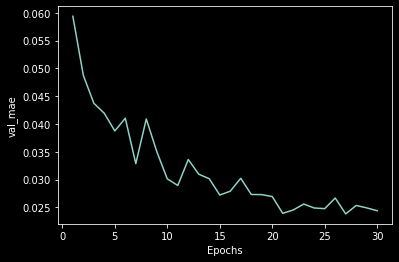

In [25]:
plt.plot(range(1, len(average_mae_history[:30]) + 1), average_mae_history[:30])
plt.xlabel('Epochs')
plt.ylabel('val_mae')
plt.show()

In [28]:
def smooth_curve(points, factor =0.9):
    
    smoothed_points = []
    
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
        
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history)

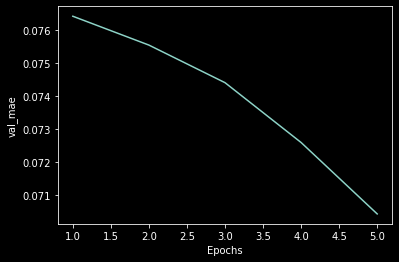

In [29]:
# Difficult to understand plot due to scaling issues
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('val_mae')
plt.show()